In [23]:
#%% import packages

import csv, glob, os, numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from scipy.signal import medfilt
from scipy.optimize import curve_fit
from matplotlib import rcParams

#make size of axis tick labels larger
label_size = 15 
plt.rcParams['xtick.labelsize'] = label_size 
plt.rcParams['ytick.labelsize'] = label_size

In [24]:
#%% define functions for fitting

#single Lorentz peak
def lorentz(x, x0, w, amp):
    lorentz_numerator = amp * np.square(w)
    lorentz_denominator = np.pi*w*(np.square(x-x0)+np.square(w))
    return np.divide(lorentz_numerator, lorentz_denominator)

#multiple Lorentz peaks
def multilorentz(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        ctr = params[i]
        amp  = params[i+1]
        wid = params[i+2]
        numerator = amp * np.square(wid)
        denominator = np.pi*wid*(np.square(x-ctr)+np.square(wid))
        y = y + np.divide(numerator, denominator)
    return y

#single Gauss peak
def gauss(x, mean, stdev, intensity):
    prefactor = intensity*np.divide(1,np.sqrt(2*np.pi*np.square(stdev)))
    exponent = -np.divide(np.square(x-mean),2*np.square(stdev))
    return prefactor * np.exp(exponent)

#multiple Gauss peaks
def multigauss(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        ctr = params[i]
        amp = params[i+1]
        wid = params[i+2]
        y = y + amp * np.exp( -((x - ctr)/wid)**2)
    return y

In [25]:
#%% set fitting parameters

#set function to use for peak fitting
fitting_function = multilorentz

#specify number of peaks to fit
peaks = 3 

#create emtpy arrays for high and low fitting bounds
lowbounds=np.zeros(peaks*3)
highbounds=np.copy(lowbounds)

In [26]:
#%% Set fitting guesses and fitting bounds

#The current parameters are used for the example data.

#See scipy.optimize.curve_fit documentation for more info:
# https://docs.scipy.org/doc/scipy/reference
#/generated/scipy.optimize.curve_fit.html

#set guesses for peak centers, heights, and widths,
#and populate appropriate bounds for fitting parameters

#for multiple Gauss fits:
if fitting_function == multigauss:
    
    #for fitting peaks conductance (Gp) peaks
    guess = [44.788, 15, 0.01, 
             44.811, 60, 0.01,
             #44.813, 15, 0.004,
             #44.813, .1, 0.004,
             44.852, 80, 0.001]
    for i in range(0,len(lowbounds), 3):
        lowbounds[i] = 44.76 #center low
        lowbounds[i+1] = 10 #amplitude low
        lowbounds[i+2] = 0.00005 #width low
        highbounds[i] = 44.86 #center high
        highbounds[i+1] = 100 #amplitude high
        highbounds[i+2] = 0.04 #width high
    
    #for fitting Rs peaks
    '''
    guess = [44.79, 0.1, 0.01, 
             44.81, .1, 0.01,
             44.813, .1, 0.004,
             #44.813, .1, 0.004,
             44.852, .3, 0.001]
    for i in range(0,len(lowbounds), 3):
        lowbounds[i] = 44.76 #center low
        lowbounds[i+1] = 0.04 #amplitude low
        lowbounds[i+2] = 0.00005 #width low
        highbounds[i] = 44.86 #center high
        highbounds[i+1] = 2.5 #amplitude high
        highbounds[i+2] = 0.05 #width high
    '''
    
#for multiple Lorentz fits:   
if fitting_function == multilorentz:
    
    #for fitting conductance (Gp) peaks
    guess = [44.79, 2, 0.01, 
             #44.80, 5, 0.0077,
             44.81, 2, 0.0058,
             #44.812, 1, 0.001,
             #44.813, 1, 0.001,
             44.85, 8, 0.0017]
    for i in range(0,len(lowbounds), 3):
        lowbounds[i] = 44.76 #center low
        lowbounds[i+1] = .1 #amplitude low
        lowbounds[i+2] = 0.00005 #width low
        highbounds[i] = 44.86 #center high
        highbounds[i+1] = 10 #amplitude high
        highbounds[i+2] = 0.03 #width high
    
    
    #for fitting Rs peaks
    ''' 
    guess = [44.79, 0.02, 0.01, 
             44.80, 0.05, 0.0077,
             44.81, 0.02, 0.0058,
             #44.812, 0.01, 0.001,
             #44.813, 0.01, 0.001,
             44.85, 0.01, 0.0017]   
    for i in range(0,len(lowbounds), 3):
        lowbounds[i] = 44.76 #center low
        lowbounds[i+1] = 0.005 #amplitude low
        lowbounds[i+2] = 0.00005 #width low
        highbounds[i] = 44.86 #center high
        highbounds[i+1] = 0.1 #amplitude high
        highbounds[i+2] = 0.03 #width high
    '''

#create tuple of bounds to be used for curve-fitting
fitbounds = (lowbounds, highbounds)

In [27]:
#% Import impedance files

#import files from folder which contains 
#only exported SARK-110 xlsx files 
folder = glob.glob('C:\\Users\\a6q\\example_SARK_spectra/*')

#sort files by time created
folder.sort(key=os.path.getmtime)

print('found ' + format(len(folder)) + ' impedance files') 

found 5 impedance files


In [28]:
#%% Find size of each imported spectrum

#skip first couple points per spctrum, as they are often distorted
data_skip = 3 

#read the first spectrum in folder
data_example_full = pd.read_excel(folder[0], skiprows=3)
data_example = data_example_full.values[data_skip:,:]

#get frequency range in MHz
freq = data_example[:,0]

#change this if you want to offset resonant frequency to be = 0 
res_freq0 = 0

spectrum number 0


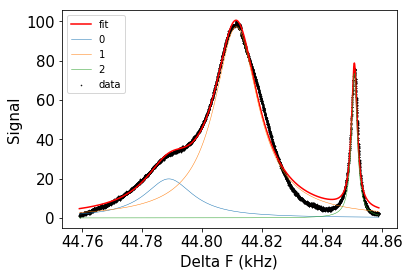

spectrum number 1


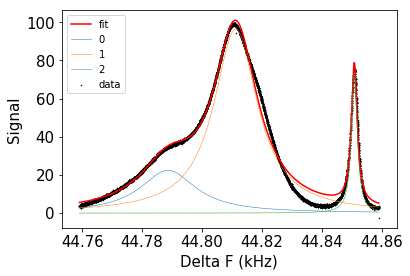

spectrum number 2


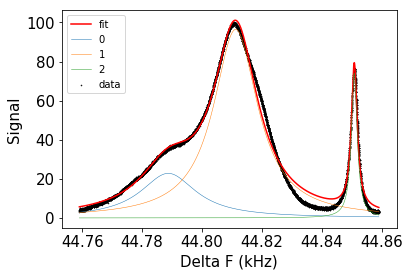

spectrum number 3


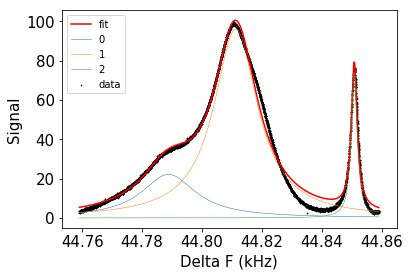

spectrum number 4


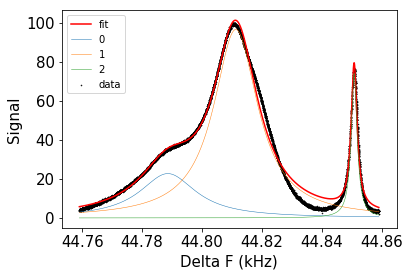

elapsed time = 0.44 minutes


In [29]:
#%% Analyze every file in folder of impedance spectra

# organize data

#start timer
starttime = time.time()

#empty array of varaible of interest to populate
var_list = np.empty((len(freq), len(folder)+1))
#set first column of variable array to be the frequency
var_list[:,0] = freq

#create empty array to store the maximum values of the variable
var_max_list = np.array([])

#create empty array to store the resonant frequency of each spectra
res_freq_list = np.array([])

#create empty arrays to store centers, 
#amplitudes, and centers of each fitted peak 
all_centers = np.zeros((len(folder), peaks))
all_amplitudes = np.zeros((len(folder), peaks))
all_widths = np.zeros((len(folder), peaks))

#create empty array to store the fitted peaks 
single_peaks = np.zeros((len(freq), peaks))

#loop over each file in folder
for i in range(len(folder)): 
    print('spectrum number '+format(i))
    
    #read in spectrum
    data_raw = pd.read_excel(folder[i], skiprows=3)
    
    #select the varaible of interest. here we are using 
    #'Gp', which is conductance. all variables named "var" 
    #now refer to the variable you specify here
    var_spectrum_raw = 1e6*np.array(data_raw['Gp'])[data_skip:]
    
    #apply median filter to each spectrum to smooth it (optional)
    var_spectrum_filt = medfilt(var_spectrum_raw, kernel_size=3)
    
    #find max value of variable and store it
    var_max = np.max(var_spectrum_filt)
    var_max_list = np.append(var_max_list, var_max)
    
    var_spectrum = var_spectrum_filt + (100-var_max)
    var_list[:,i+1] = var_spectrum    
    res_freq_list = np.append(res_freq_list,
                              freq[np.argmax(var_spectrum)])
    
    #plot spectrum of variable
    plt.scatter(freq-res_freq0, var_spectrum, c='k',
                s=0.3, label='data')
    
    #calculate fitting parameters based on 
    #previously-determined guesses and bounds
    popt, pcov = curve_fit(fitting_function, freq-res_freq0, 
                           var_spectrum,
                           p0=guess, bounds=fitbounds)
    
    #calculate the fit using the fit parameters
    calculated_fit = fitting_function(freq-res_freq0, *popt)
    
    #plot the fit
    plt.plot(freq-res_freq0, calculated_fit, c='r', label='fit')
        
    # save fit parameters
    centers0 = np.array([])
    amplitudes0 = np.array([])
    widths0 = np.array([])
    for j in range(0,len(popt),3):
        centers0 = np.append(centers0, popt[j])
        amplitudes0 = np.append(amplitudes0, popt[j+1])
        widths0 = np.append(widths0, popt[j+2])    

    #plot deconvoluted peaks
    for k in range(len(centers0)):
        
        if fitting_function == multilorentz:
            single_peak = np.divide(amplitudes0[k]*
                                    np.square(widths0[k]),
                                    np.pi*widths0[k]*
                                    (np.square(
                                        freq-res_freq0-centers0[k])
                                     +np.square(widths0[k])))
            
        if fitting_function == multigauss:
            single_peak = amplitudes0[k]*
            np.exp(-((freq-res_freq0-centers0[k])/widths0[k])**2)
         
        #save peaks
        single_peaks[:,k] = single_peak
        plt.plot(freq-res_freq0, single_peak,
                 linewidth=0.5, label=format(k))
    
    #save deconvoluted peak info
    all_centers[i,:] = centers0
    all_amplitudes[i,:] = amplitudes0
    all_widths[i,:] = widths0
    
    plt.xlabel('Delta F (kHz)', fontsize=label_size)    
    plt.ylabel('Signal', fontsize=label_size)
    plt.legend()
    plt.show()

endtime = time.time()
tottime = (endtime-starttime)/60
print('elapsed time = %.2f minutes' %tottime)

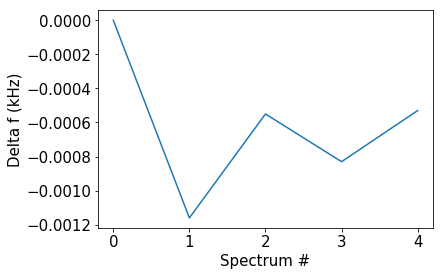

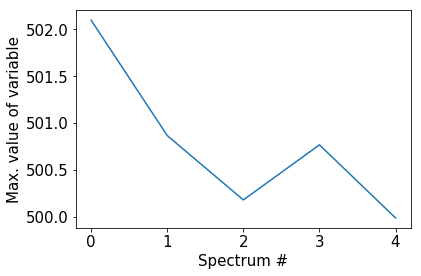

In [30]:
#%% Plot the changes in the spectra over time

#offset to correct for the resonant frequency 
res_freq_list_corr = res_freq_list - res_freq_list[0]

#plot resonant frequency
plt.plot(res_freq_list_corr)
plt.xlabel('Spectrum #', fontsize=label_size)
plt.ylabel('Delta f (kHz)', fontsize=label_size)
plt.show()

#plot maximum value of the variable of interest
plt.plot(var_max_list)
plt.xlabel('Spectrum #', fontsize=label_size)
plt.ylabel('Max. value of variable',fontsize=label_size)
plt.show()
